- Première étape afficher la corrélation entre le temps de résolution et la priority ainsi que le moyen de contact
- Retirer toutes les lignes dont l'incident n'est pas résolu ou clos
- Créer une nouvelle dataframe avec seulement les valeurs qui nous intéressent pour faire la régréssion

In [0]:
# Lié son drive afin d'avoir accès aux docs du drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import datetime as dt
from   random import randint
import math
import re
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import svm
from pylab import *
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Fonctions

In [0]:
def colonne_to_int(dataframe, colonne):
  for col in colonne:
    dataframe[col] = [int(re.findall('\d+', x)[0]) if x != '?' else np.nan for x in dataframe[col]]

In [0]:
def notify_colonne(dataframe):
  dataframe['notify'] = [bool(False) if x == 'Do Not Notify' else bool(True) for x in dataframe['notify']]

# Code

## Chargement des données

In [0]:
df_incident_log_event = pd.read_csv("drive/My Drive/incident_event_log.csv", sep=",", encoding="latin-1")
df_incident_log_event

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 21,29/2/2016 01:23,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 642,29/2/2016 08:53,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 804,29/2/2016 11:29,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 908,5/3/2016 12:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,?,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,Created by 171,29/2/2016 04:57,Updated by 746,29/2/2016 04:57,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,?,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 89,True,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141707,INC0120835,Closed,False,1,0,4,True,Caller 116,Opened by 12,16/2/2017 09:09,?,?,Updated by 27,16/2/2017 09:53,Email,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3 - Moderate,Group 31,Resolver 10,False,True,Do Not Notify,?,?,?,?,code 9,Resolved by 9,16/2/2017 09:53,16/2/2017 09:53
141708,INC0121064,Active,True,0,0,0,True,Caller 116,Opened by 12,16/2/2017 14:17,?,?,Updated by 908,16/2/2017 14:17,Email,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 10,False,False,Do Not Notify,?,?,?,?,code 6,Resolved by 9,16/2/2017 16:38,16/2/2017 16:38
141709,INC0121064,Active,True,1,0,1,True,Caller 116,Opened by 12,16/2/2017 14:17,?,?,Updated by 60,16/2/2017 15:20,Email,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3 - Moderate,Group 31,?,False,False,Do Not Notify,?,?,?,?,code 6,Resolved by 9,16/2/2017 16:38,16/2/2017 16:38
141710,INC0121064,Resolved,True,1,0,2,True,Caller 116,Opened by 12,16/2/2017 14:17,?,?,Updated by 27,16/2/2017 16:38,Email,Location 204,Category 42,Subcategory 223,Symptom 494,?,2 - Medium,2 - Medium,3 - Moderate,Group 31,Resolver 10,False,True,Do Not Notify,?,?,?,?,code 6,Resolved by 9,16/2/2017 16:38,16/2/2017 16:38


## Analyse et transformation des données

### Valeur = "?"

NaN Value per column :

number                  : None

incident_state          : -100 --> 5

active                  : None

reassignment_count      : None

reopen_count            : None

sys_mod_count           : None

made_sla                : None

caller_id               : "?" --> 50aine

opened_by               : "?" --> 5K

opened_at               :  None 

sys_created_by          : "?" --> 70K

sys_created_at          : "?" --> 70K

sys_updated_by          : None

contact_type            : None

location                : "?" --> 600 environ

category                : "?" --> 600 environ

subcategory             : "?" --> 700 environ

u_symptom               : "?" --> 40K

cmdb_ci	                : "?" --> Toute la db quasiement

impact                  : None

urgency                 : None

priority                : None

assignment_group        : "?" --> 14K

assigned_to             : "?" --> 30K

knowledge               : None

u_priority_confirmation : None

notify                  : None

problem_id              : "?" --> Toute la db quasiement

rfc                     : "?" --> Toute la db quasiement

vendor                  : "?" --> Toute la db quasiement

caused_by               : "?" --> Toute la db quasiement

closed_code             : "?" --> 1K environ

resolved_by             : "?" --> 300

resolved_at             : "?" --> 3800

closed_at               : None


Tout cela implique que l'on va retirer les colonnes ayant le tag "Toute la DB quasiement"

In [0]:
# Aide à vérifier les valeurs "?"
df_incident_log_event['closed_code'].unique()

In [0]:
# Aide à vérifier la taille de la DF après avoir drop les valeurs "?" dans une colonne en particulier
df_incident_log_event.drop(df_incident_log_event[df_incident_log_event["closed_code"] == "?"].index)

In [0]:
# Drop des colonnes où les valeurs "?" sont trop présentes ainsi que la colonne "resolved_at"
df_incident_log_event = df_incident_log_event.drop(columns=["cmdb_ci", "problem_id", "rfc", "vendor", "caused_by", "resolved_at"], axis=1)

### Transformation des types

In [0]:
df_incident_log_event

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 21,29/2/2016 01:23,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,code 5,Resolved by 149,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 642,29/2/2016 08:53,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,code 5,Resolved by 149,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 804,29/2/2016 11:29,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,code 5,Resolved by 149,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 908,5/3/2016 12:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,3 - Moderate,Group 56,?,True,False,Do Not Notify,code 5,Resolved by 149,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,Created by 171,29/2/2016 04:57,Updated by 746,29/2/2016 04:57,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 89,True,False,Do Not Notify,code 5,Resolved by 81,6/3/2016 10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141707,INC0120835,Closed,False,1,0,4,True,Caller 116,Opened by 12,16/2/2017 09:09,?,?,Updated by 27,16/2/2017 09:53,Email,Location 204,Category 42,Subcategory 223,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 31,Resolver 10,False,True,Do Not Notify,code 9,Resolved by 9,16/2/2017 09:53
141708,INC0121064,Active,True,0,0,0,True,Caller 116,Opened by 12,16/2/2017 14:17,?,?,Updated by 908,16/2/2017 14:17,Email,Location 204,Category 42,Subcategory 223,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 10,False,False,Do Not Notify,code 6,Resolved by 9,16/2/2017 16:38
141709,INC0121064,Active,True,1,0,1,True,Caller 116,Opened by 12,16/2/2017 14:17,?,?,Updated by 60,16/2/2017 15:20,Email,Location 204,Category 42,Subcategory 223,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 31,?,False,False,Do Not Notify,code 6,Resolved by 9,16/2/2017 16:38
141710,INC0121064,Resolved,True,1,0,2,True,Caller 116,Opened by 12,16/2/2017 14:17,?,?,Updated by 27,16/2/2017 16:38,Email,Location 204,Category 42,Subcategory 223,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 31,Resolver 10,False,True,Do Not Notify,code 6,Resolved by 9,16/2/2017 16:38


In [0]:
df_incident_log_event_copy = df_incident_log_event.copy()

In [0]:
# On définit les colonnes à transformer en int (en supprimant la partie str)
colonnes = ['caller_id', 'opened_by', 'sys_created_at','sys_created_by', 'sys_updated_by',
            'location', 'category', 'subcategory', 'u_symptom', 'impact', 'urgency', 'priority', 
            'assignment_group', 'assigned_to', 'closed_code', 'resolved_by']

# On transforme les colonnes en int
colonne_to_int(df_incident_log_event_copy, colonnes) # Transforme les colonnes en type int

# On transforme la colonne notify
notify_colonne(df_incident_log_event_copy) # Transforme la colonne notify en type Booléen

# On transforme les colonnes en datetime afin de faciliter
df_incident_log_event_copy["opened_at"]   = pd.to_datetime(df_incident_log_event_copy.opened_at, format="%d/%m/%Y %H:%M")
df_incident_log_event_copy["closed_at"]   = pd.to_datetime(df_incident_log_event_copy.closed_at, format="%d/%m/%Y %H:%M")

# On transforme la colonne des dates en datetime
le = preprocessing.LabelEncoder()
le.fit(['Phone', 'Email', 'Self service', 'Direct opening', 'IVR']) # 0 = Direct Opening | 1 = Email | 2 = IVR | 3 = Phone | 4 = Self Service
df_incident_log_event_copy["contact_type"] = le.transform(df_incident_log_event_copy["contact_type"])

In [0]:
df_incident_log_event_copy

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by,closed_at
0,INC0000045,New,True,0,0,0,True,2403.0,8.0,2016-02-29 01:16:00,6.0,29.0,21,29/2/2016 01:23,3,143.0,55.0,170.0,72.0,2,2,3,56.0,NaN,True,False,False,5.0,149.0,2016-03-05 12:00:00
1,INC0000045,Resolved,True,0,0,2,True,2403.0,8.0,2016-02-29 01:16:00,6.0,29.0,642,29/2/2016 08:53,3,143.0,55.0,170.0,72.0,2,2,3,56.0,NaN,True,False,False,5.0,149.0,2016-03-05 12:00:00
2,INC0000045,Resolved,True,0,0,3,True,2403.0,8.0,2016-02-29 01:16:00,6.0,29.0,804,29/2/2016 11:29,3,143.0,55.0,170.0,72.0,2,2,3,56.0,NaN,True,False,False,5.0,149.0,2016-03-05 12:00:00
3,INC0000045,Closed,False,0,0,4,True,2403.0,8.0,2016-02-29 01:16:00,6.0,29.0,908,5/3/2016 12:00,3,143.0,55.0,170.0,72.0,2,2,3,56.0,NaN,True,False,False,5.0,149.0,2016-03-05 12:00:00
4,INC0000047,New,True,0,0,0,True,2403.0,397.0,2016-02-29 04:40:00,171.0,29.0,746,29/2/2016 04:57,3,165.0,40.0,215.0,471.0,2,2,3,70.0,89.0,True,False,False,5.0,81.0,2016-03-06 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141707,INC0120835,Closed,False,1,0,4,True,116.0,12.0,2017-02-16 09:09:00,NaN,NaN,27,16/2/2017 09:53,1,204.0,42.0,223.0,494.0,2,2,3,31.0,10.0,False,True,False,9.0,9.0,2017-02-16 09:53:00
141708,INC0121064,Active,True,0,0,0,True,116.0,12.0,2017-02-16 14:17:00,NaN,NaN,908,16/2/2017 14:17,1,204.0,42.0,223.0,494.0,2,2,3,70.0,10.0,False,False,False,6.0,9.0,2017-02-16 16:38:00
141709,INC0121064,Active,True,1,0,1,True,116.0,12.0,2017-02-16 14:17:00,NaN,NaN,60,16/2/2017 15:20,1,204.0,42.0,223.0,494.0,2,2,3,31.0,NaN,False,False,False,6.0,9.0,2017-02-16 16:38:00
141710,INC0121064,Resolved,True,1,0,2,True,116.0,12.0,2017-02-16 14:17:00,NaN,NaN,27,16/2/2017 16:38,1,204.0,42.0,223.0,494.0,2,2,3,31.0,10.0,False,True,False,6.0,9.0,2017-02-16 16:38:00


## Ajout de nouvelles colonnes

In [0]:
df_incident_log_event_copy['time_to_resolve'] = df_incident_log_event_copy.apply(lambda x: round((x['closed_at'] - x['opened_at']).total_seconds()/3600, 2), axis = 1)
df_incident_log_event_copy['during_day']      = df_incident_log_event_copy.apply(lambda x: True if (x['opened_at'].hour > 20 or x['opened_at'].hour < 8) else False, axis = 1)
df_incident_log_event_copy['day']             = df_incident_log_event_copy.apply(lambda x: x['opened_at'].isoweekday(), axis = 1)
df_incident_log_event_copy['month']           = df_incident_log_event_copy.apply(lambda x: x['opened_at'].month, axis = 1)

In [0]:
df_incident_log_event_copy

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by,closed_at,time_to_resolve,during_day,day,month
0,INC0000045,New,True,0,0,0,True,2403.0,8.0,2016-02-29 01:16:00,6.0,29.0,21,29/2/2016 01:23,3,143.0,55.0,170.0,72.0,2,2,3,56.0,NaN,True,False,False,5.0,149.0,2016-03-05 12:00:00,130.73,True,1,2
1,INC0000045,Resolved,True,0,0,2,True,2403.0,8.0,2016-02-29 01:16:00,6.0,29.0,642,29/2/2016 08:53,3,143.0,55.0,170.0,72.0,2,2,3,56.0,NaN,True,False,False,5.0,149.0,2016-03-05 12:00:00,130.73,True,1,2
2,INC0000045,Resolved,True,0,0,3,True,2403.0,8.0,2016-02-29 01:16:00,6.0,29.0,804,29/2/2016 11:29,3,143.0,55.0,170.0,72.0,2,2,3,56.0,NaN,True,False,False,5.0,149.0,2016-03-05 12:00:00,130.73,True,1,2
3,INC0000045,Closed,False,0,0,4,True,2403.0,8.0,2016-02-29 01:16:00,6.0,29.0,908,5/3/2016 12:00,3,143.0,55.0,170.0,72.0,2,2,3,56.0,NaN,True,False,False,5.0,149.0,2016-03-05 12:00:00,130.73,True,1,2
4,INC0000047,New,True,0,0,0,True,2403.0,397.0,2016-02-29 04:40:00,171.0,29.0,746,29/2/2016 04:57,3,165.0,40.0,215.0,471.0,2,2,3,70.0,89.0,True,False,False,5.0,81.0,2016-03-06 10:00:00,149.33,True,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141707,INC0120835,Closed,False,1,0,4,True,116.0,12.0,2017-02-16 09:09:00,NaN,NaN,27,16/2/2017 09:53,1,204.0,42.0,223.0,494.0,2,2,3,31.0,10.0,False,True,False,9.0,9.0,2017-02-16 09:53:00,0.73,False,4,2
141708,INC0121064,Active,True,0,0,0,True,116.0,12.0,2017-02-16 14:17:00,NaN,NaN,908,16/2/2017 14:17,1,204.0,42.0,223.0,494.0,2,2,3,70.0,10.0,False,False,False,6.0,9.0,2017-02-16 16:38:00,2.35,False,4,2
141709,INC0121064,Active,True,1,0,1,True,116.0,12.0,2017-02-16 14:17:00,NaN,NaN,60,16/2/2017 15:20,1,204.0,42.0,223.0,494.0,2,2,3,31.0,NaN,False,False,False,6.0,9.0,2017-02-16 16:38:00,2.35,False,4,2
141710,INC0121064,Resolved,True,1,0,2,True,116.0,12.0,2017-02-16 14:17:00,NaN,NaN,27,16/2/2017 16:38,1,204.0,42.0,223.0,494.0,2,2,3,31.0,10.0,False,True,False,6.0,9.0,2017-02-16 16:38:00,2.35,False,4,2


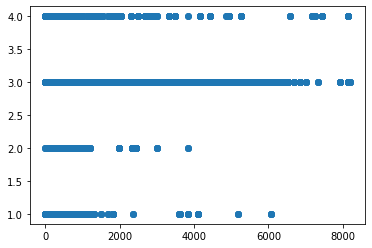

In [69]:
plt.plot_date(df_incident_log_event_copy["time_to_resolve"].values, df_incident_log_event_copy["priority"].values, xdate=False)

In [0]:
df_correlation = df_incident_log_event_copy.copy()

In [0]:
df_correlation2 = df_correlation.groupby(
   ['number']
).agg(
    {
        'incident_state': 'last',
        'reassignment_count': 'last',
        'reopen_count':	'last',
        'sys_mod_count': 'last',
        'made_sla': 'last',
     	  'caller_id': 'last',
        'opened_by': 'first',
     	  'sys_created_by': 'first',
        'sys_updated_by': 'last',
        'contact_type': 'first',
        'location': 'first',
        'category': 'first',
        'subcategory': 'first',
        'u_symptom': 'first',
        'impact': 'last',
        'urgency': 'last',
        'priority':	'last',
        'assignment_group':	'last',
        'assigned_to': 'last',
        'knowledge': 'first',
        'u_priority_confirmation': 'first',
        'notify':	'last',
        'resolved_by': 'last',
        'time_to_resolve': 'last',
        'during_day': 'last',
        'day'	: 'last',
        'month': 'last',
    }
    )

In [0]:
df_correlation3 = df_correlation2.copy()

In [0]:
df_correlation3.dropna(inplace=True)

In [0]:
df_correlation2

,incident_state,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,sys_created_by,sys_updated_by,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,resolved_by,time_to_resolve,during_day,day,month
number,,,,,,,,,,,,,,,,,,,,,,,,,,,
INC0000045,Closed,0,0,4,True,2403.0,8.0,6.0,908,3,143.0,55.0,170.0,72.0,2,2,3,56.0,NaN,True,False,False,149.0,130.73,True,1,2
INC0000047,Closed,1,0,8,True,2403.0,397.0,171.0,908,3,165.0,40.0,215.0,471.0,2,2,3,24.0,89.0,True,False,False,81.0,149.33,True,1,2
INC0000057,Closed,0,0,6,True,4416.0,8.0,NaN,908,3,204.0,20.0,125.0,471.0,2,2,3,70.0,6.0,True,False,False,5.0,140.83,True,1,2
INC0000060,Closed,0,0,3,True,4491.0,180.0,81.0,908,3,204.0,9.0,97.0,450.0,2,2,3,25.0,125.0,True,False,False,113.0,174.37,True,1,2
INC0000062,Closed,1,0,7,False,3765.0,180.0,81.0,908,3,93.0,53.0,168.0,232.0,1,2,2,23.0,NaN,True,False,False,62.0,129.03,True,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INC0120304,Closed,0,0,2,True,90.0,8.0,NaN,21,1,188.0,52.0,177.0,494.0,2,2,3,64.0,6.0,False,False,False,5.0,46.80,True,3,2
INC0120319,Closed,0,0,1,True,1899.0,508.0,NaN,931,2,246.0,50.0,10.0,533.0,3,2,4,70.0,NaN,False,False,False,NaN,0.00,True,3,2
INC0120495,Closed,1,0,5,True,323.0,14.0,NaN,845,3,135.0,59.0,210.0,483.0,2,2,3,24.0,217.0,False,False,False,NaN,21.88,False,3,2


In [0]:
df_correlation3

,incident_state,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,sys_created_by,sys_updated_by,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,resolved_by,time_to_resolve,during_day,day,month
number,,,,,,,,,,,,,,,,,,,,,,,,,,,
INC0000047,Closed,1,0,8,True,2403.0,397.0,171.0,908,3,165.0,40.0,215.0,471.0,2,2,3,24.0,89.0,True,False,False,81.0,149.33,True,1,2
INC0000060,Closed,0,0,3,True,4491.0,180.0,81.0,908,3,204.0,9.0,97.0,450.0,2,2,3,25.0,125.0,True,False,False,113.0,174.37,True,1,2
INC0000064,Closed,1,0,8,True,2838.0,131.0,62.0,908,3,143.0,53.0,168.0,580.0,2,2,3,28.0,78.0,True,False,False,71.0,201.83,True,1,2
INC0000065,Closed,6,0,13,True,5323.0,131.0,62.0,908,3,108.0,44.0,229.0,580.0,2,2,3,33.0,216.0,True,False,False,197.0,176.37,True,1,2
INC0000067,Closed,1,0,10,True,442.0,180.0,81.0,908,3,143.0,9.0,110.0,470.0,2,2,3,28.0,236.0,True,False,False,215.0,171.95,False,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INC0111993,Closed,0,0,12,False,5234.0,14.0,8.0,908,3,108.0,45.0,150.0,494.0,1,1,1,10.0,37.0,False,False,False,35.0,126.73,False,2,1
INC0113197,Closed,3,0,18,False,3490.0,333.0,143.0,908,4,217.0,56.0,171.0,494.0,2,2,3,65.0,35.0,False,False,False,34.0,452.02,False,4,1
INC0113256,Closed,1,0,5,True,4326.0,305.0,130.0,908,3,8.0,14.0,71.0,411.0,2,2,3,20.0,93.0,False,False,False,84.0,208.10,False,4,1


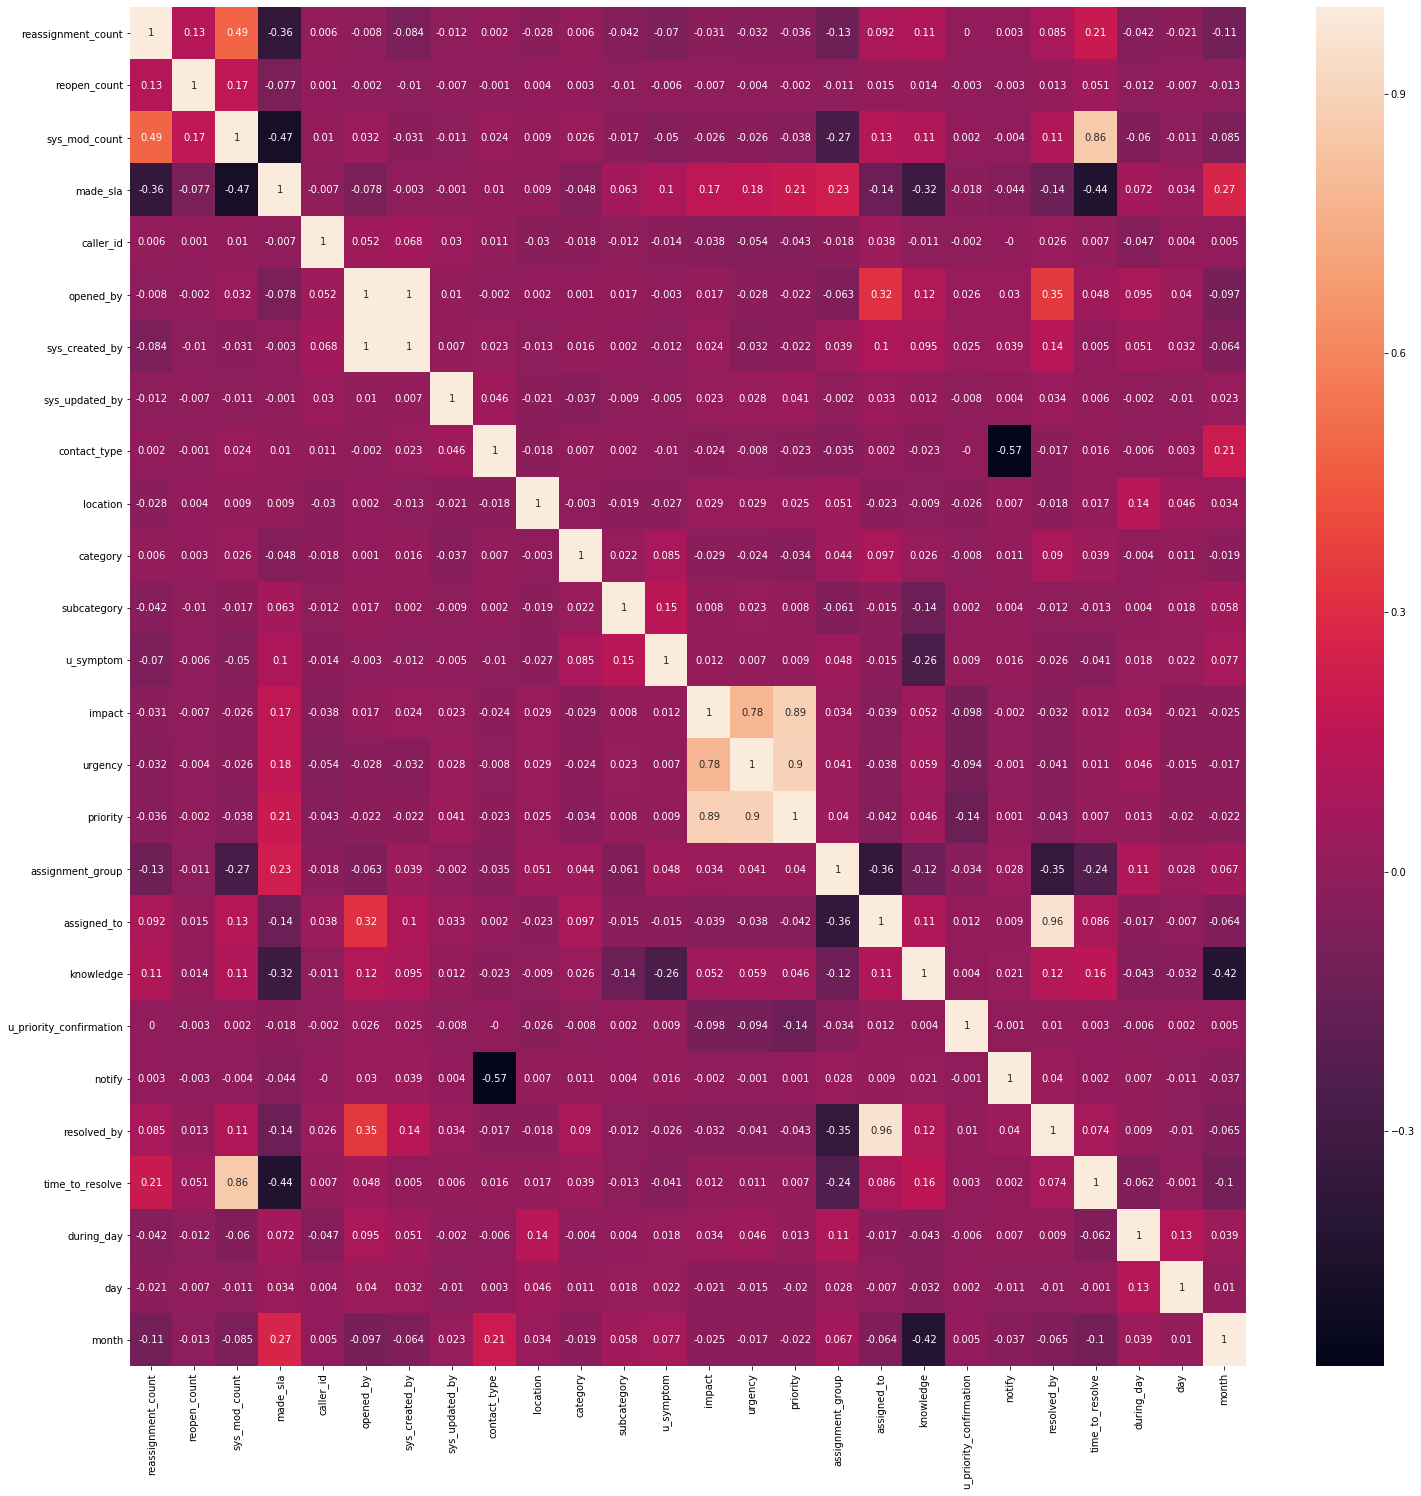

In [0]:
matrice_corr = df_correlation2.corr().round(3)
plt.figure(figsize=(25,25))
sns.heatmap(data=matrice_corr, annot=True)

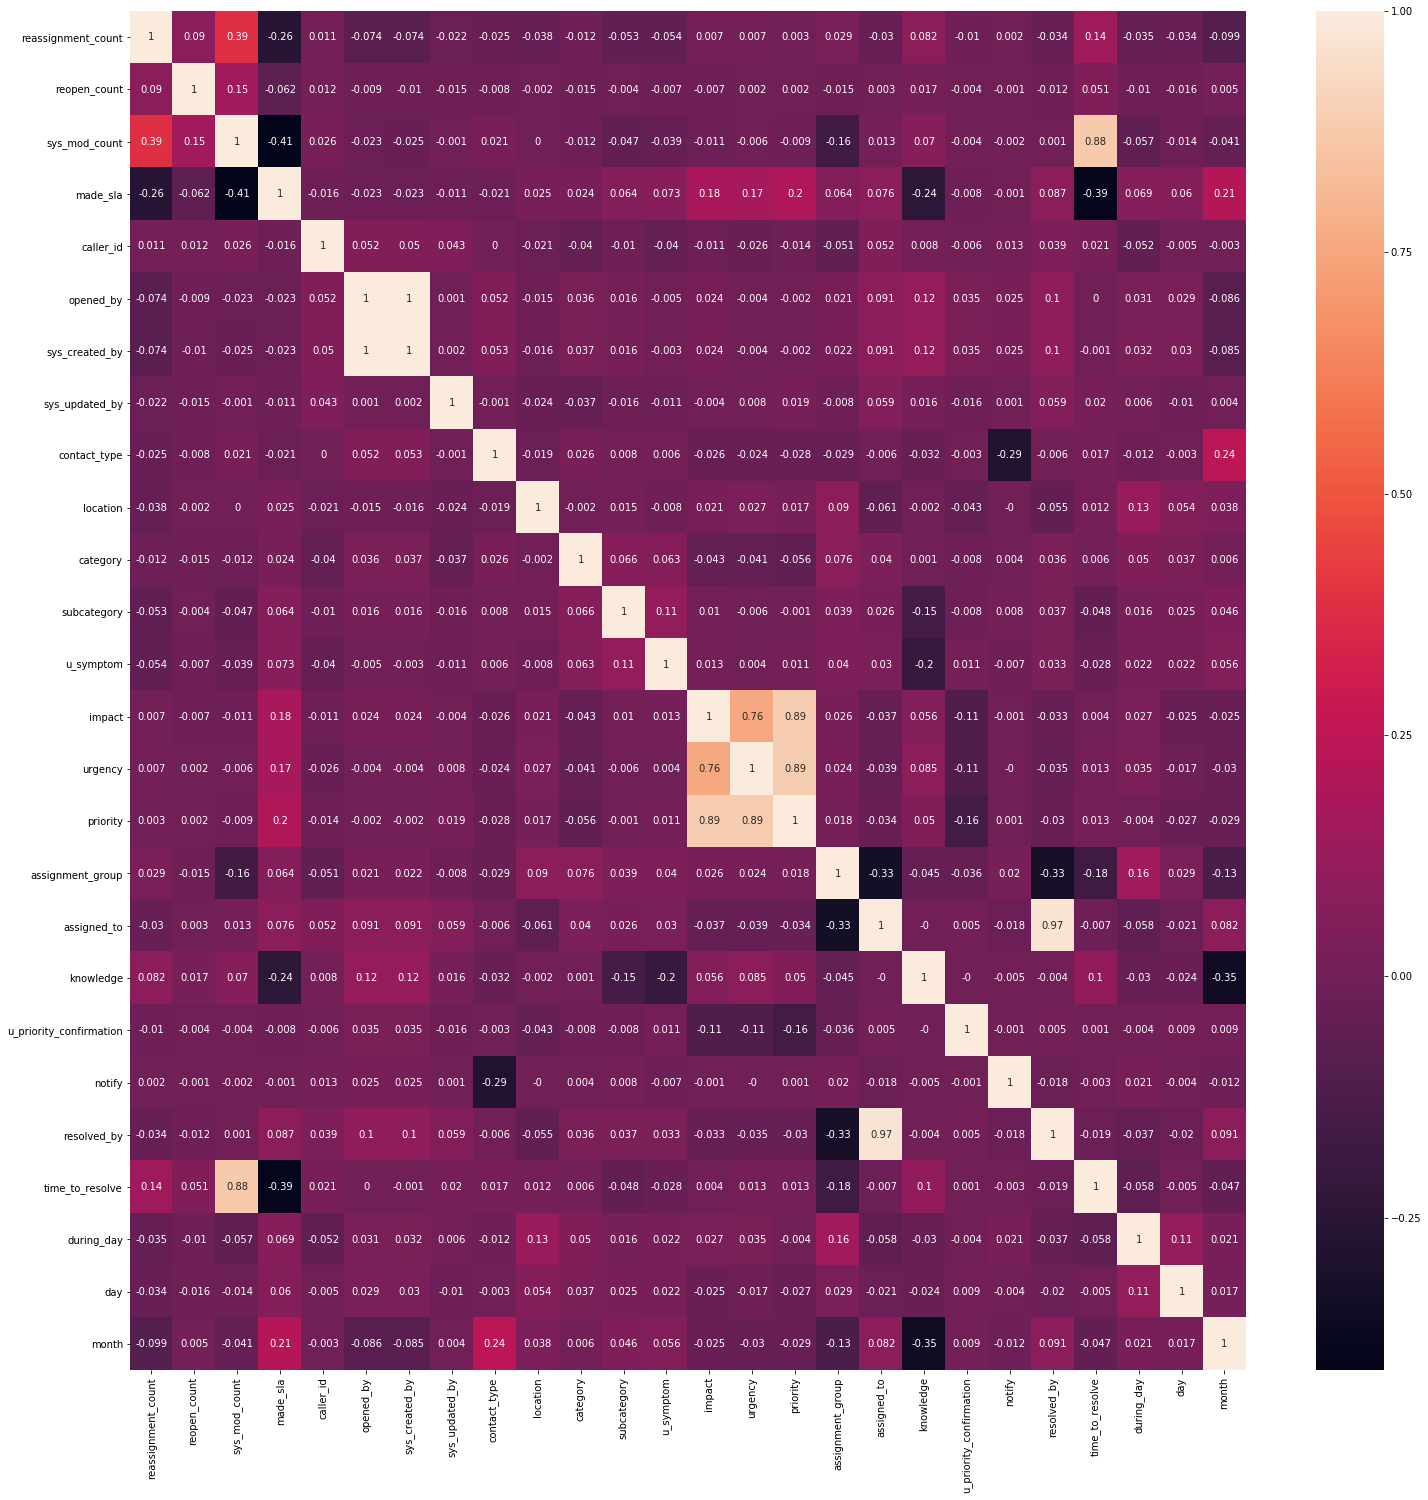

In [72]:
matrice_corr = df_correlation3.corr().round(3)
plt.figure(figsize=(25,25))
sns.heatmap(data=matrice_corr, annot=True)

In [0]:
X = df_correlation3.copy() #["sys_mod_count", "made_sla", "reassignment_count", "assignment_group", "knowledge"]
y = df_correlation3.copy() #["time_to_resolve"]

X.drop(["incident_state", "reopen_count",	"caller_id", "opened_by",	"sys_created_by",	"sys_updated_by",	"contact_type",	"location",	"category",	"subcategory",	"u_symptom",	"impact",	"urgency",	"priority",	"assigned_to",	"u_priority_confirmation",	"notify",	"resolved_by",	"time_to_resolve",	"during_day",	"day",	"month"], axis=1, inplace=True)
y.drop(["incident_state", "sys_mod_count", "made_sla", "reassignment_count", "assignment_group", "knowledge", "reopen_count",	"caller_id",	"opened_by",	"sys_created_by",	"sys_updated_by",	"contact_type",	"location",	"category",	"subcategory",	"u_symptom",	"impact",	"urgency",	"priority",	"assigned_to",	"u_priority_confirmation",	"notify",	"resolved_by",	"during_day",	"day",	"month"], axis=1, inplace=True)

In [0]:
print(shape(X), shape(y))

(9641, 5) (9641, 1)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7230, 5), (2411, 5), (7230, 1), (2411, 1))

In [0]:
scores = dict()

In [0]:
def get_score(algorithme, X_train, X_test, y_train, y_test, display_graph=False, display_options=True):
    if display_options:
        print("fitting :\n"+ str(algorithme))
        print("X_train:{} , X_test:{} ,  y_train:{} ,  y_test:{}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
    modele = algorithme.fit(X_train, y_train)
    score  = modele.score(X_test, y_test)
    if display_graph:
        plt.scatter(x=y_test, y=algorithme.predict(X_test)) ## Predictions against True values
    return score

fitting :
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
X_train:(7230, 5) , X_test:(2411, 5) ,  y_train:(7230, 1) ,  y_test:(2411, 1)
0.8341631300863055


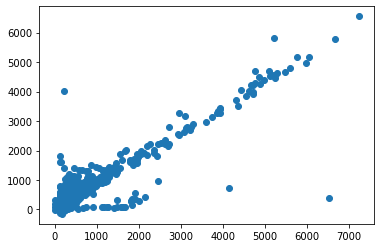

In [97]:
algorithme = LinearRegression()
scre = get_score(algorithme, X_train, X_test, y_train, y_test, True)
scores[algorithme] = scre
print(scre)

fitting :
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
X_train:(7230, 5) , X_test:(2411, 5) ,  y_train:(7230, 1) ,  y_test:(2411, 1)
0.7992905645556176


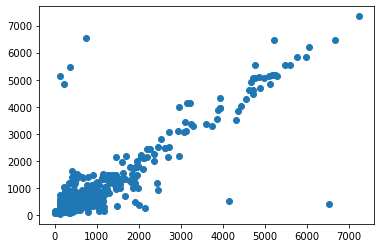

In [98]:
algorithme = DecisionTreeRegressor()
scre = get_score(algorithme, X_train, X_test, y_train, y_test, True)
scores[algorithme] = scre
print(scre)

In [0]:
i = 1
score_rf = 0
n_estimator_rf = 0
while i < 51:
  hyperparametres = { 'n_estimators':i }
  algorithme = RandomForestRegressor(**hyperparametres)
  scr = get_score(algorithme, X_train, X_test, y_train, y_test, False, False)
  if score_rf < scr:
    score_rf = scr
    n_estimator_rf = i 
  i = i + 1

scores[algorithme] = score_rf

In [100]:
print(score_rf, n_estimator_rf)

0.8852381481814323 20


In [0]:
i = 1
score_extra_trees = 0
n_estimator_extra_trees = 0
while i < 51:
  hyperparametres = { 'n_estimators':i }
  algorithme = ExtraTreesRegressor(**hyperparametres)
  scr = get_score(algorithme, X_train, X_test, y_train, y_test, False, False)
  if score_extra_trees < scr:
    score_extra_trees = scr
    n_estimator_extra_trees = i
  i = i + 1
scores[algorithme] = score_extra_trees

In [102]:
print(score_extra_trees, n_estimator_extra_trees)

0.8558887676553952 11


fitting :
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
X_train:(7230, 5) , X_test:(2411, 5) ,  y_train:(7230, 1) ,  y_test:(2411, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8012781986791738


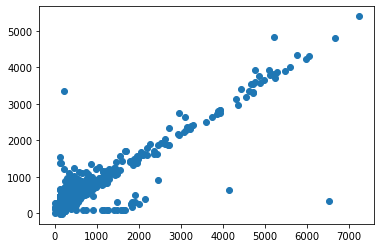

In [103]:
algorithme = svm.SVR(kernel='linear')
scre = get_score(algorithme, X_train, X_test, y_train, y_test, True)
scores[algorithme] = scre
print(scre)

In [106]:
score_algorithme = pd.DataFrame()
score_algorithme["Score"] = scores.values()
score_algorithme["Algorithme"] = scores.keys()
score_algorithme['Nom_algorithme'] = score_algorithme.Algorithme.apply(lambda x: str(x).split('(')[0]) #Permet de récupérer le nom dans la colonne Algorithme
score_algorithme.set_index('Nom_algorithme', inplace=True)
score_algorithme.sort_values(by="Score", inplace=True)
score_algorithme

,Score,Algorithme
Nom_algorithme,,
DecisionTreeRegressor,0.799291,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
SVR,0.801278,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3..."
LinearRegression,0.834163,"LinearRegression(copy_X=True, fit_intercept=Tr..."
ExtraTreesRegressor,0.855889,"(ExtraTreeRegressor(ccp_alpha=0.0, criterion='..."
RandomForestRegressor,0.885238,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio..."


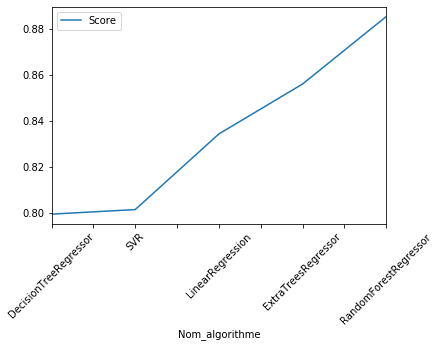

In [107]:
score_algorithme[["Score"]].plot(kind='line', rot=45)